# Set up virtual display to watch the environments

In [ ]:
!python -m pip install pyvirtualdisplay
!sudo apt-get install xvfb
!apt-get install swig
!pip install box2d box2d-kengz
!pip install glfw
!pip install gymnasium
!pip install pygame

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.16).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 0s (2,455 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 121713 f

# Import gym and torch to make our models

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import copy

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from pyvirtualdisplay import Display
display = Display(visible=0, size=(780, 420))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

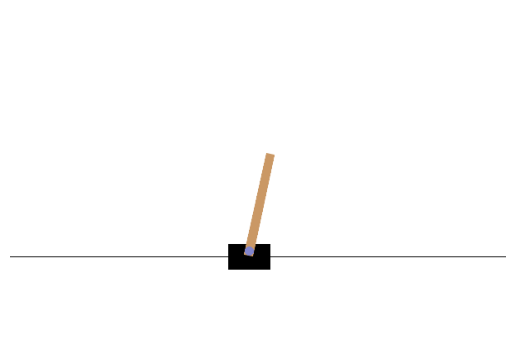

In [ ]:
# Run the cartpole environment
env = gym.make('CartPole-v1', render_mode='rgb_array')
obs1 = env.reset()
img = plt.imshow(env.render())

terminated = False # The cart has not dropped the pole or gone out of bounds
truncated = False # We have not reached max iterations

while not terminated and not truncated:
  action = env.action_space.sample() # random action
  obs1, reward, terminated, truncated, info = env.step(action) #Env Step

  #collab displa stuff
  clear_output(wait=True)
  img.set_data(env.render())
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)

# Make a memory buffer for our model to sample from to be more efficient with our data

In [ ]:
#From torch dqn example
import math
import random
# Format following Machine learning with phil memory buffer
class memory_buffer():
  def __init__(self, num_steps, action_size, state_size, device):
    self.mem_size = num_steps
    self.states = np.zeros((num_steps,state_size))
    self.states_ = np.zeros((num_steps,state_size))
    self.actions = np.zeros((num_steps,action_size))
    self.rewards = np.zeros((num_steps))
    self.terminated = np.zeros((num_steps),dtype=np.int32)
    self.idx = 0
    self.steps_recorded = 0

  def save_transition(self, state, action, reward, state_, terminated):
    self.states[self.idx] = state
    self.states_[self.idx] = state_
    self.actions[self.idx] = action
    self.rewards[self.idx] = reward
    self.terminated[self.idx] = terminated
    self.idx = (self.idx + 1) % self.mem_size
    self.steps_recorded = min(self.steps_recorded + 1, self.mem_size)

  def sample(self, batch_size, idx:np.ndarray=None):
    size = min(self.steps_recorded, batch_size)
    if idx is None:
      idx = np.random.choice(self.steps_recorded, size)
    return (self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.states_[idx],
            self.terminated[idx])

  def reset(self):
    self.idx = 0
    self.steps_recorded=0




Q and value functions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Q Network for deep RL
class Q(nn.Module):
  def __init__(self, input_size, hidden_dims=[64,64], output_size=2, device='cuda'):
    super(Q, self).__init__()
    self.layers = []
    self.layers.append(nn.Linear(input_size, hidden_dims[0]))
    for i in range(1,len(hidden_dims)):
      self.layers.append(nn.Linear(hidden_dims[i-1],hidden_dims[i]))
    self.layers.append(nn.Linear(hidden_dims[-1], output_size))
    self.layers = nn.ModuleList(self.layers)
    self.to(device)

  def forward(self, x):
    for i,l in enumerate(self.layers):
      if i<len(self.layers)-1:
        x = torch.relu(l(x))
      else:
        x = l(x)
    return x

#Value Network for deep RL
class V(nn.Module):
  def __init__(self, input_size, hidden_dims=[64,64], output_size=1, device='cuda'):
    super(V, self).__init__()
    self.layers = []
    self.layers.append(nn.Linear(input_size, hidden_dims[0]))
    for i in range(1,len(hidden_dims)):
      self.layers.append(nn.Linear(hidden_dims[i-1],hidden_dims[i]))
    self.layers.append(nn.Linear(hidden_dims[-1], 1))
    self.layers = nn.ModuleList(self.layers)
    self.to(device)

  def forward(self, x):
    for i,l in enumerate(self.layers):
      if i<len(self.layers)-1:
        x = torch.relu(l(x))
      else:
        x = l(x)
    return x

class Policy(nn.Module):
  def __init__(self, state_size, action_size, hidden_dims=[64,64], output_size=2,device='cuda'):
    super(Policy, self).__init__()
    self.h1 = torch.nn.Linear(state_size, hidden_dims[0])
    self.h2 = torch.nn.Linear(hidden_dims[0],hidden_dims[1])
    self.out = torch.nn.Linear(hidden_dims[1], action_size)
    self.to(device)

  def forward(self, x):
    x = F.relu(self.h1(x))
    x = F.relu(self.h2(x))
    x = self.out(x)
    return x

# Delayed Deep Q Network with Temporal Difference error

In [ ]:
class Deep_Q_Agent():
  def __init__(self,
               state_size,
               action_size,
               hidden_sizes=[128,128],
               gamma=0.99,
               learning_rate=0.001,
               batch_size=128,
               eps_start=0.9,
               eps_end=0.05,
               eps_decay=1000,
               memory_size=10000,
               device='cuda',
               update_every=1,
               # TODO: if the target is hard-updated every timestep, then we are doing
               # Standard DQN. We want the target to be delayed to reduce Bias. Try
               # 16 or 32 and later try polyak averaging and report the results.
               target_every=1):
    # This is our online Q network where we want to track
    # the gradient to update the weights
    self.Q = Q(state_size, hidden_dims=hidden_sizes, output_size=action_size,device=device)

    with torch.no_grad():
      # We do not want Q_Target to be updated by an optimizer
      # We want it to just give us a training target.
      self.Q_Target = Q(state_size, hidden_dims=hidden_sizes, output_size=action_size,device=device)
      self.Q_Target.load_state_dict(self.Q.state_dict())
      # no_grad() and .eval() is being extra careful, one
      # or the other should be fine
      self.Q_Target.eval()

    self.Q_optimizer = optim.Adam(self.Q.parameters(), lr=learning_rate, amsgrad=True)
    self.memory = memory_buffer(num_steps=memory_size,
                                action_size=1,
                                state_size=state_size,
                                device=device)
    self.action_size = action_size
    self.up_num = 0 # determins how often we update the q network
    self.targ_num = 0 # determins how often we copy the q network in number of q updates
    self.update_every = update_every
    self.targ_every = target_every
    self.gamma = gamma

    self.eps_start = eps_start
    self.eps_end = eps_end
    self.eps_decay = eps_decay
    self.batch_size=batch_size
    self.device=device
    self.tau = 0.01


  def select_action(self, state:np.ndarray, eps:float):
    sample = random.random()

    # Eps action
    if sample > eps:
        with torch.no_grad():
            Q_vals = self.Q(torch.FloatTensor(state).to(self.device))
            action = torch.argmax(Q_vals).item()
        return action
    # Greedy action
    else:
        return np.random.randint(0,self.action_size)

  def q_loss(self,states,actions,states_,rewards,terminated):
    # Moving batch to tensors so torch can use them
    r_t = torch.FloatTensor(rewards).to(self.device)
    s_t = torch.FloatTensor(states).to(self.device)
    s_t_ = torch.FloatTensor(states_).to(self.device)
    term_t = torch.FloatTensor(terminated).to(self.device)
    a_t = torch.LongTensor(actions).to(self.device)

    # Remember:
    # loss = (
    #        reward + (1-done)*gamma*max_a(Q_targ(s', a))
    #        - Q(s,a)
    #        )^2
    # We want to use the temporal difference loss here

    # No grad for the target because we don't want to move our
    # future estimate (that has more information) towards our
    # current estimate (which we are trying to udate)
    with torch.no_grad():
      # -----------Lecture-Note--------------------------------------
      # If the target network is used to select the next
      # action "(max(Q_Target(states_)))" then the selected
      # value will be positively biased. Think of a state with
      # True Q vals [0.4,0.4] and our target network hasn't
      # finished learning so it has estimated [0.41,0.38].
      # It will pick the action with positive estimation noise/error
      # then return that over-estimate. If our online network has
      # unrelated estimation noise then it will be a 50/50 whether
      # we get the 0.41 or the 0.38 so the target is no longer biased
      # This is the Double-Q learning innovation over typical DQN
      #--------------------------------------------------------------
      # TODO: Complete the update function
      online_q_next = self.Q(s_t_)
      next_best_actions = torch.argmax(online_q_next, dim=-1).unsqueeze(-1)
      target_q_vals = self.Q_Target(s_t_)
      next_selected_q = target_q_vals.gather(1,next_best_actions).squeeze(-1)

      # print(f"r {r_t.shape} t {term_t.shape} q {next_selected_q.shape}")
      td_targets = r_t + self.gamma * (1-term_t) * next_selected_q

    # Selecting the Q values for the historical actions that were taken
    # so we can update our estimate by looking at the future targets
    q_vals = self.Q(s_t) # Getting Q values for states
    q_vals = q_vals.gather(1,a_t).squeeze(-1)
    q_loss = ((q_vals-td_targets)**2).mean()

    return q_loss

  def update(self,state,action,reward,state_,terminated,truncated):
    self.up_num +=1
    #print(f"state: {state} , action: {action}, reward: {reward}, state_: {state_} term trunc {terminated} {truncated}")
    self.memory.save_transition(state,action,reward,state_,int(terminated))
    loss = torch.zeros(1)
    # Don't want to sample data until we actually have some
    if self.up_num%self.update_every==0 and self.up_num>self.batch_size*4:
      self.targ_num +=1
      states,actions,rewards,states_,terminated = self.memory.sample(self.batch_size)
      loss = self.q_loss(states,actions,states_,rewards,terminated)

      self.Q_optimizer.zero_grad()
      loss.backward()
      # you can try In-place gradient clipping if the parameters go wild
      # torch.nn.utils.clip_grad_value_(self.Q.parameters(), 10)
      self.Q_optimizer.step()

      #Target Hard Update
      if self.targ_num%self.targ_every==0: # Every so often we update the target Q
        self.Q_Target.load_state_dict(self.Q.state_dict())

      # TODO: target network polyak partial update if using Q delayed target
      # We can also move the target net towards the Q net a little each timestep
      # Instead of taking a big step every so often
      # Q_targ_state_dict = self.Q_Target.state_dict()
      # Q_state_dict = self.Q.state_dict()
      # for key in Q_state_dict:
      #   Q_targ_state_dict[key] = Q_state_dict[key]*self.tau + Q_targ_state_dict[key]*(1-self.tau)
      # self.Q_Target.load_state_dict(Q_state_dict)

    return loss.item()

# Discrete Vanilla Policy Gradient (VPG)
## With a learned value baseline

In [ ]:
@torch.jit.script
def calculate_discounted_return_torch(rewards: torch.Tensor, gamma: float) -> torch.Tensor:
  """
  Calculates the discounted return G for a single terminal episode.
  """
  # Initialize output tensor
  g_returns = torch.zeros_like(rewards)
  g = 0.0
  # The JIT compiler optimizes this loop significantly
  for t in range(len(rewards) - 1, -1, -1):
    g = rewards[t] + gamma * g
    g_returns[t] = g

  return g_returns

class Discrete_VPG():
  def __init__(self,
               state_size,
               action_size,
               hidden_sizes=[128,128],
               gamma=0.99,
               V_learning_rate = 2e-4,
               A_learning_rate = 2e-4,
               device='cuda',
               #TODO: Modify the entropy coefficient to 0.0, 0.01, 0.1 and report the results
               entropy_coeficient = 0.1):
    self.e_coef = entropy_coeficient
    self.device=device
    self.V = V(state_size, hidden_dims=hidden_sizes, output_size=action_size,device=device)
    self.V_optimizer = optim.AdamW(self.V.parameters(), lr=V_learning_rate, amsgrad=True)

    self.pi = Policy(
      state_size=state_size,
      action_size=action_size,
      hidden_dims=hidden_sizes,
      output_size=action_size,
      device=device
    )
    self.memory = memory_buffer(num_steps=5000,
                                action_size=1,
                                state_size=state_size,
                                device=device)
    self.pi_optim = torch.optim.Adam(self.pi.parameters(), lr = A_learning_rate)
    self.gamma = gamma


  def select_action(self,obs,env):
    with torch.no_grad():
      act = self.pi(torch.FloatTensor(obs).to(self.device))
      probs = torch.nn.Softmax(dim=-1)(act)
      return np.random.choice(2, p = probs.cpu().numpy())


  def v_loss(self,S,A,S_,R,dones):
    # Episodic return (only works because we sampled the transitions in order)
    with torch.no_grad(): #No reason to track gradient for the target Q network
      G = calculate_discounted_return_torch(R,self.gamma)
    v = self.V(S) # Getting values for states
    adv = G-v
    v_loss = ((adv)**2)

    #TODO: Train Replace G with G - baseline and report the difference in training
    return v_loss, G

  def update(self,state,action,reward,state_,terminated,truncated):
    self.memory.save_transition(state,action,reward,state_,int(terminated))
    if not terminated:
      return

    # These get sampled in order to calculate the episodic returns
    S,A,R,S_,Term = self.memory.sample(
      idx=np.arange(0,self.memory.steps_recorded,1),
      batch_size=self.memory.steps_recorded
    )

    # Sending the data to tensors to be used by torch for update
    S_t = torch.FloatTensor(S).to(self.device)
    S_t_ = torch.FloatTensor(S_).to(self.device)
    R_t = torch.FloatTensor(R).to(self.device)
    A_t = torch.LongTensor(A).to(self.device)
    Term_t = torch.FloatTensor(Term).to(self.device)

    # Critic update
    loss, adv = self.v_loss(S_t,A_t,S_t_,R_t,Term_t)
    loss = loss.mean()
    self.V_optimizer.zero_grad()
    loss.backward()
    self.V_optimizer.step()

    # Lecture Note:
    # We just need this as a "reward" for the actor. We don't want the actor update
    # To accidentally update the critic that was used to generate this advantage
    adv = adv.detach()

    # Actor Update
    log_probs = torch.log_softmax(self.pi(S_t),dim=-1) # Get the log probabilities from pi
    prob = torch.exp(log_probs) # Get probs (More stable than doing it the other way around)
    entropy = -(prob*log_probs).sum(dim=1) # Calculate entropy
    log_probs = log_probs.gather(1, A_t).squeeze(-1)
    # Get the log probs for the actions we actually took

    self.pi_optim.zero_grad()
    objective = -(adv.detach() * log_probs + self.e_coef*entropy)
    objective = objective.mean()
    # Loss is policy gradient loss - entropy because we want the policy to not converge too fast
    objective.backward()
    self.pi_optim.step()

    self.memory.reset()
    return objective.item()

# Continuous Vanilla Policy Gradient (VPG)
## With a learned value baseline

In [ ]:
#VPG agent
from math import log
import copy

class VPG_Continuous:
  def __init__(self,
               state_size,
               action_size,
               hidden_sizes=[64,64],
               gamma=0.99,
               learning_rate=2e-4,
               device='cuda',
               policy_train_iter=1):
    self.device = device
    self.gamma=gamma
    self.learning_rate=learning_rate
    self.episode_states = []
    self.episode_actions = []
    self.episode_rewards = []
    self.policy_train_iter=policy_train_iter
    self.action_size = action_size
    self.max_action = 2
    self.LOG_STD_MAX = 2
    self.LOG_STD_MIN = -5

    #TODO modify for continuos action
    self.pi = Policy(
      state_size=state_size,
      action_size=action_size,
      hidden_dims=hidden_sizes,
      output_size=action_size,
      device=device
    )

    # Optimizers
    self.pi_optim = torch.optim.Adam(self.pi.parameters(), lr = learning_rate)

    # TODO
    # self.V = ...
    # self.V_optim = ...

  # Policy
  def select_action(self,obs,env):
    with torch.no_grad():
      act = self.pi(torch.FloatTensor(obs).to(self.device))
      probs = torch.nn.Softmax(dim=-1)(act)
      return np.random.choice(2, p = probs.cpu().numpy())

      #TODO continuous action
      #logits = self.pi(torch.FloatTensor(obs).to(self.device))
      #means = logits[:self.action_size].cpu().numpy()
      #log_stds = torch.clamp(logits[self.action_size:],self.LOG_STD_MIN,self.LOG_STD_MAX).cpu().numpy()
      #s = np.random.normal(means, np.exp(log_stds))
      #return self.max_action * (np.tanh(s)-0.5) * 2



  # Training function
  # S = tensor of states observed in the episode/ batch of episodes
  # A = tensor of actions taken in episode/ batch of episodes
  # return = tensor where nth element is \sum^{T-n}_0 gamma^n * reward (return at step n of episode)
  def param_update(self,S,A,returns):
    #number of policy improvement steps given the observation
    # TODO
    # Belman error update V using returns as a target something like (returns - V(states))
    # Use discrete as example

    for i in range(self.policy_train_iter):
        self.pi_optim.zero_grad()
        # collect pi(a | s) for trajectories
        log_probs = torch.nn.LogSoftmax(dim=-1)(self.pi(S)).gather(1, A.view(-1, 1)).view(-1)

        #TODO
        # Continuous action log probs are harder to get but possible
        #logits = self.pi(torch.FloatTensor(S).to(self.device))
        #means = logits[:self.action_size]
        #log_stds = torch.clamp(logits[self.action_size:],self.LOG_STD_MIN,self.LOG_STD_MAX)
        #logits = Normal(means, torch.exp(log_stds))
        #log_probs = logits.log_prob(A).sum(axis=-1)
        #log_probs -= (2*(np.log(2) - A - F.softplus(-2*A))).sum(axis=1)

        # TODO
        # Advantage = (returns - V baseline)
        # Use advantage instead of flat returns as a baseline
        # Also try normalized returns
        n = torch.arange(S.size(0)).to(self.device)
        objective = -(returns * log_probs).sum()
        objective.backward()
        self.pi_optim.step()


  def update(self,state,action,reward,state_,terminated,truncated):
    self.episode_states.append(state)
    self.episode_rewards.append(reward)
    self.episode_actions.append(action)

    if terminated or truncated:
      discounted_rewards = copy.deepcopy(self.episode_rewards)
      for i in range(len(self.episode_rewards)-1)[::-1]:
        discounted_rewards[i] += self.gamma * discounted_rewards[i+1]
      discounted_rewards = torch.FloatTensor(discounted_rewards).to(self.device)

      S = torch.FloatTensor(self.episode_states).to(self.device)
      A = torch.Tensor(self.episode_actions).long().to(self.device)
      # TODO continuous action replace A with this
      #A = torch.Tensor(np.arctanh(np.array(self.episode_actions)/self.max_action+0.5)).to(self.device)
      R = torch.Tensor(discounted_rewards).to(self.device)
      self.param_update(S,A,R)

      self.episode_states  = []
      self.episode_rewards = []
      self.episode_actions = []


# Training loop for our models

In [ ]:
# Train Deep RL Agents
device = 'cuda'
obs=None
agent = 'cont-vpg'
N_STEPS = 100000

if agent=='dq':
  agent = Deep_Q_Agent(state_size=4,
                action_size=2,
                hidden_sizes=[64,64],
                gamma=0.99,
                learning_rate=3e-4,
                batch_size=64,
                eps_start=0.9,
                eps_end=0.05,
                memory_size=10000,
                device=device,
                update_every=1,
                # TODO: Try hard updating the target every to 16 or 32 instead of every 1 timestep
                # Then try polyak averaging with target_every=1
                target_every=1)
elif agent=='disc-vpg':
  agent = Discrete_VPG(
                state_size=4,
                action_size=2,
                hidden_sizes=[128,128],
                gamma=0.99,
                V_learning_rate=5e-4,
                A_learning_rate=5e-4,
                device=device,
                #TODO: Try entropy 0.0, 0.01, 0.1
                entropy_coeficient=0.0,
                )
if agent=='cont-vpg':
  # TODO: Switch to pendulum env and uncomment the continuous action code
  # Check the shapes of each tensor in the equations to make sure all
  # Shapes are the same. For example, if V-R will cause problems if
  # V.shape = [64,1] and R.shape = [64] so use squeeze or unsqueeze

  agent = VPG_Continuous(state_size=4, # 3 for pendulum
                action_size=2, # 1 for continuous action
                hidden_sizes=[128,128],
                gamma=0.99,
                learning_rate=5e-4,
                device=device)

# Run the cartpole environment
def run_cartpole(agent, render=False, train_step=0):
  #Pendulum-v1   for continuous action
  env = gym.make('CartPole-v1', render_mode='rgb_array')
  obs,_ = env.reset()
  #img = plt.imshow(env.render())
  tot_reward = 0
  tot_loss = 0

  terminated = False # The cart has not dropped the pole or gone out of bounds
  truncated = False # We have not reached max iterations
  max_step = 500
  step = 0
  while not terminated and not truncated:
    eps = (N_STEPS - 1.5*train_step)/N_STEPS
    eps = max(eps,0.05)
    action = agent.select_action(obs, eps)# Q agent action
    obs_, reward, terminated, truncated, info = env.step(action) #Env Step to use continuous on cartpole do int(action[0]>0) or to use discrete model on pendulum do [3*(action-0.5)]
    loss = agent.update(obs,action,reward,obs_,terminated,truncated) #Agent update
    #print(f"obs: {obs} obs_: {obs_} loss: {loss} eps: {eps}")
    obs=obs_
    tot_reward += reward
    if loss is not None:
      tot_loss += loss
    #Render the environment
    step+=1
    if step >=max_step:
      truncated = True
    #clear_output(wait=True)
    #display.clear_output(wait=True)
    if render:
      env.render()
      #clear_output(wait=True)
      #img.set_data(env.render(mode='rgb_array')[0])
      #plt.axis('off')
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
  return tot_reward, tot_loss, step

rs = []
r_smooth = 0
r_smoothed = []
ls = []
stot = 0
ep_num = 0
while stot < N_STEPS:
  r, l, s = run_cartpole(agent,render=False, train_step=stot)
  stot+=s
  ep_num+=1
  rs.append(r)
  ls.append(l)
  r_smooth = 0.99*r_smooth + 0.01*r
  r_smoothed.append(r_smooth)
  print(f"{stot/N_STEPS*100:.4f}% r: {r}, r_smooth: {r_smooth:.4f}, episode_mean_loss: {l/s:.4f}")


/tmp/ipython-input-863306798.py:103: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  S = torch.FloatTensor(self.episode_states).to(self.device)


0.0130% r: 13.0, r_smooth: 0.1300, episode_mean_loss: 0.0000
0.0280% r: 15.0, r_smooth: 0.2787, episode_mean_loss: 0.0000
0.0440% r: 16.0, r_smooth: 0.4359, episode_mean_loss: 0.0000
0.0690% r: 25.0, r_smooth: 0.6816, episode_mean_loss: 0.0000
0.0920% r: 23.0, r_smooth: 0.9047, episode_mean_loss: 0.0000
0.1110% r: 19.0, r_smooth: 1.0857, episode_mean_loss: 0.0000
0.1270% r: 16.0, r_smooth: 1.2348, episode_mean_loss: 0.0000
0.1410% r: 14.0, r_smooth: 1.3625, episode_mean_loss: 0.0000
0.1510% r: 10.0, r_smooth: 1.4489, episode_mean_loss: 0.0000
0.1620% r: 11.0, r_smooth: 1.5444, episode_mean_loss: 0.0000
0.1760% r: 14.0, r_smooth: 1.6689, episode_mean_loss: 0.0000
0.1950% r: 19.0, r_smooth: 1.8422, episode_mean_loss: 0.0000
0.2130% r: 18.0, r_smooth: 2.0038, episode_mean_loss: 0.0000
0.2490% r: 36.0, r_smooth: 2.3438, episode_mean_loss: 0.0000
0.2860% r: 37.0, r_smooth: 2.6903, episode_mean_loss: 0.0000
0.3000% r: 14.0, r_smooth: 2.8034, episode_mean_loss: 0.0000
0.3630% r: 63.0, r_smoot

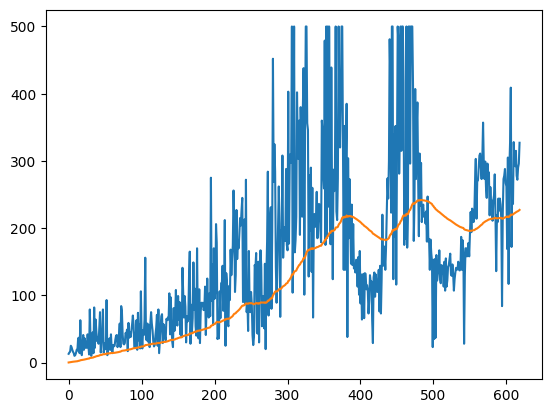

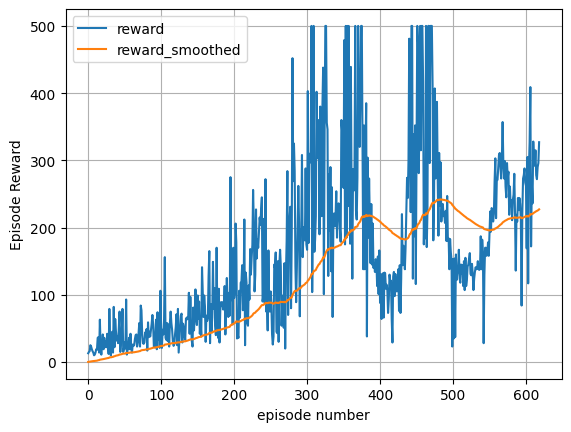

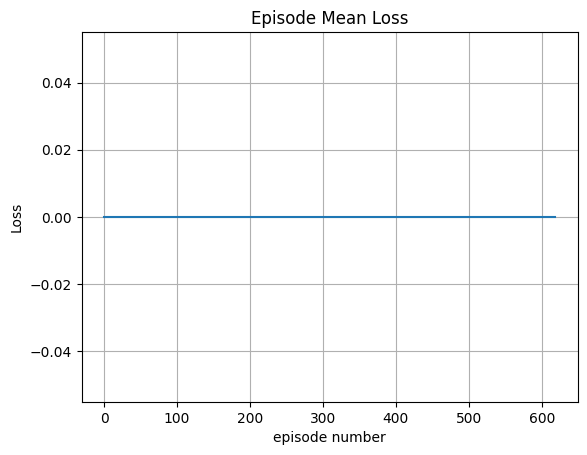

In [ ]:
plt.close()
plt.plot(rs)
plt.plot(r_smoothed)
plt.show()

plt.plot(rs)
plt.plot(r_smoothed)
plt.xlabel("episode number")
plt.ylabel("Episode Reward")
plt.legend(["reward","reward_smoothed"])
plt.grid()
plt.show()

plt.plot(ls)
plt.title("Episode Mean Loss")
plt.xlabel("episode number")
plt.ylabel("Loss")
plt.grid()
plt.show()

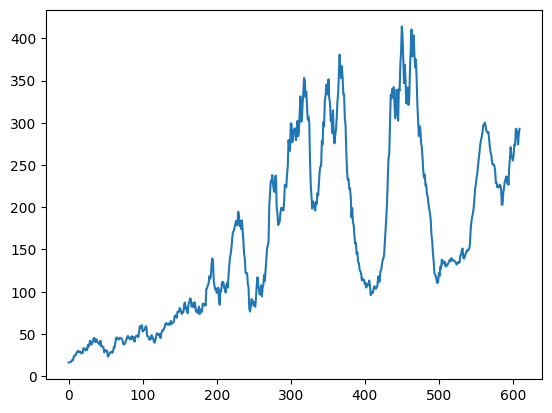

In [ ]:
#print rewards smoothed over 10 episodes
rs_conv = np.convolve(rs, np.ones(10), 'valid') / 10
plt.plot(rs_conv)
plt.show()

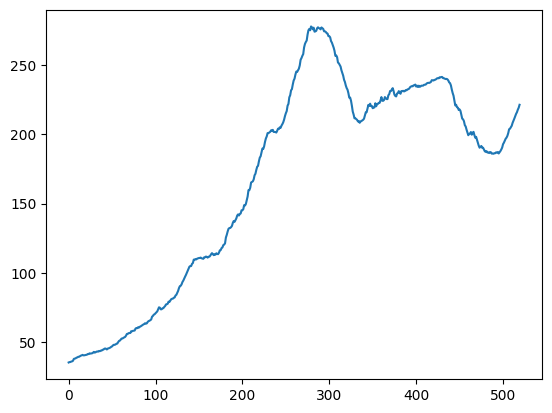

In [ ]:
#Print graph with less fine grains
rs_conv = np.convolve(rs, np.ones(100), 'valid') / 100
plt.plot(rs_conv)
plt.show()